In [34]:
from scipy import signal
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

overlap = 1024
frame_length = 2048


In [58]:
##Loading data

In [35]:
from scipy.io import wavfile

def readAudio(audio):
    fs, amp = wavfile.read(audio)
    dt = 1/fs
    n = len(amp)
    t = dt*n

    if t > 1.0:
        amp = amp[int((t/2 - 0.5)/dt):int((t/2 + 0.5)/dt)]
        n = len(amp)
        t = dt*n
    
    return(amp, fs, n, t)

In [36]:
import json
from scipy.io import wavfile
import librosa
import os


def get_spectogram(amp, fs, n, t):
    mfccs_features = librosa.feature.melspectrogram(y=amp*1.0, sr=fs, n_fft=frame_length, hop_length=overlap, power=1.0)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features


def readAudio(audio):
    fs, amp = wavfile.read(audio)
    dt = 1 / fs
    n = len(amp)
    t = dt * n

    if t > 1.0:
        amp = amp[int((t / 2 - 0.5) / dt) : int((t / 2 + 0.5) / dt)]
        n = len(amp)
        t = dt * n

    return (amp, fs, n, t)


datadir = "data"
fulldir = os.path.join(os.getcwd(), datadir)
all_diseases = os.listdir(fulldir)

for disease in all_diseases:
    filepath = os.path.join(datadir, disease)
    for filename in os.listdir(filepath):
        if filename.endswith("wav"):
            fname = os.path.join(datadir, disease, filename)
            amp, fs, n, t = readAudio(fname)
            spectogram = list(get_spectogram(amp, fs, n, t))
            name = os.path.join("data", disease, filename.split(".")[0])
            status = disease
            with open(name + ".json", "w") as f:
                data = json.dumps(
                    {
                        "spectogram": spectogram,
                        "status": status,
                    },
                )
                f.write(data)

In [37]:
datadir = 'data'
fulldir = os.path.join(os.getcwd(), datadir)
all_diseases = os.listdir(fulldir)

dataset = []

for disease in all_diseases:
    filepath = os.path.join(datadir, disease)
    for filename in os.listdir(filepath):
        fpath = os.path.join("data", disease, filename.split(".")[0] + ".json")
        with open(fpath, "r") as file:
            person = json.load(file)
            dataset.append(person)

X = []
y = []

for person in dataset:
    spectogram = person['spectogram']/np.float32(255) #normalize input pixels 
    status = person['status']
    X.append(spectogram)
    y.append(status)
X = np.array(X)
y = np.array(y)

print(X)


print('X shape: ', X.shape, 'y shape: ', y.shape)

[[8.50187039e+01 2.31331329e+01 1.08422242e+01 ... 7.66225128e-02
  7.62469166e-02 7.96878106e-02]
 [8.50187039e+01 2.31331329e+01 1.08422242e+01 ... 7.66225128e-02
  7.62469166e-02 7.96878106e-02]
 [1.72901807e+01 5.52023835e+00 3.91344870e+00 ... 3.09657223e-02
  2.73865739e-02 2.88062488e-02]
 ...
 [6.59347986e+01 3.20557703e+01 1.68428226e+01 ... 7.02197978e-02
  6.96418193e-02 7.36294108e-02]
 [1.66434211e+01 5.59839348e+00 3.46945692e+00 ... 5.76294108e-02
  5.89561284e-02 6.12257844e-02]
 [1.66434211e+01 5.59839348e+00 3.46945692e+00 ... 5.76294108e-02
  5.89561284e-02 6.12257844e-02]]
X shape:  (2216, 128) y shape:  (2216,)


In [38]:
import pandas as pd
import tensorflow

from tensorflow.keras import datasets, layers, models

extracted_features_df=pd.DataFrame(dataset,columns=['spectogram','status'])
extracted_features_df.shape

(2216, 2)

In [39]:
xx=np.array(extracted_features_df['spectogram'].tolist())
y=np.array(extracted_features_df['status'].tolist())
xx.shape

(2216, 128)

In [59]:
#Data Divison 

In [40]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))


print(y)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(xx,y,test_size=0.2,stratify=y,random_state=0)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [41]:
X_train.shape

(1772, 128)

In [42]:
X_test.shape

(444, 128)

In [43]:
y_train.shape

(1772, 2)

In [44]:
y_test.shape

(444, 2)

##Model Creation  

In [45]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [47]:
### No of disease
num_labels=y.shape[1]

In [48]:
model=Sequential()

###first layer
model.add(Dense(100,input_shape=(128,)))
model.add(Activation('relu'))

###second layer
model.add(Dense(50))
model.add(Activation('relu'))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               12900     
                                                                 
 activation_3 (Activation)   (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 activation_4 (Activation)   (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 102       
                                                                 
 activation_5 (Activation)   (None, 2)                 0         
                                                                 
Total params: 18,052
Trainable params: 18,052
Non-trai

In [60]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [51]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='Desktop/sbvoicedb_RdLu8Y.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_split=0.10, callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
34/50 [===================>..........] - ETA: 0s - loss: 470.9094 - accuracy: 0.6351  
Epoch 1: val_loss improved from inf to 248.62569, saving model to Desktop\sbvoicedb_RdLu8Y.hdf5
50/50 [==============================] - 0s 4ms/step - loss: 396.5645 - accuracy: 0.6455 - val_loss: 248.6257 - val_accuracy: 0.6854
Epoch 2/100
36/50 [====================>.........] - ETA: 0s - loss: 263.5741 - accuracy: 0.6293
Epoch 2: val_loss improved from 248.62569 to 152.25256, saving model to Desktop\sbvoicedb_RdLu8Y.hdf5
50/50 [==============================] - 0s 2ms/step - loss: 241.7011 - accuracy: 0.6631 - val_loss: 152.2526 - val_accuracy: 0.7416
Epoch 3/100
42/50 [========================>.....] - ETA: 0s - loss: 113.8244 - accuracy: 0.7329
Epoch 3: val_loss improved from 152.25256 to 86.66239, saving model to Desktop\sbvoicedb_RdLu8Y.hdf5
50/50 [==============================] - 0s 2ms/step - loss: 106.9144 - accuracy: 0.7415 - val_loss: 86.6624 - val_accuracy: 0.7191
Epoch 4/10

Epoch 29/100
44/50 [=========================>....] - ETA: 0s - loss: 8.7565 - accuracy: 0.8771
Epoch 29: val_loss did not improve from 25.86528
50/50 [==============================] - 0s 2ms/step - loss: 8.2598 - accuracy: 0.8833 - val_loss: 35.5899 - val_accuracy: 0.8427
Epoch 30/100
43/50 [========================>.....] - ETA: 0s - loss: 10.2896 - accuracy: 0.8772
Epoch 30: val_loss did not improve from 25.86528
50/50 [==============================] - 0s 2ms/step - loss: 10.5797 - accuracy: 0.8770 - val_loss: 37.8203 - val_accuracy: 0.8596
Epoch 31/100
43/50 [========================>.....] - ETA: 0s - loss: 6.0574 - accuracy: 0.9172
Epoch 31: val_loss did not improve from 25.86528
50/50 [==============================] - 0s 2ms/step - loss: 5.8656 - accuracy: 0.9166 - val_loss: 29.6399 - val_accuracy: 0.8427
Epoch 32/100
43/50 [========================>.....] - ETA: 0s - loss: 8.2708 - accuracy: 0.8953
Epoch 32: val_loss did not improve from 25.86528
50/50 [=====================

50/50 [==============================] - 0s 2ms/step - loss: 1.6979 - accuracy: 0.9636 - val_loss: 15.0713 - val_accuracy: 0.8876
Epoch 58/100
42/50 [========================>.....] - ETA: 0s - loss: 2.4314 - accuracy: 0.9457
Epoch 58: val_loss did not improve from 15.07132
50/50 [==============================] - 0s 2ms/step - loss: 2.6036 - accuracy: 0.9454 - val_loss: 15.8305 - val_accuracy: 0.8652
Epoch 59/100
44/50 [=========================>....] - ETA: 0s - loss: 3.8437 - accuracy: 0.9339
Epoch 59: val_loss did not improve from 15.07132
50/50 [==============================] - 0s 2ms/step - loss: 4.0128 - accuracy: 0.9310 - val_loss: 17.9952 - val_accuracy: 0.8876
Epoch 60/100
 1/50 [..............................] - ETA: 0s - loss: 1.4011 - accuracy: 0.9688
Epoch 60: val_loss did not improve from 15.07132
50/50 [==============================] - 0s 2ms/step - loss: 3.0881 - accuracy: 0.9348 - val_loss: 19.3918 - val_accuracy: 0.8596
Epoch 61/100
38/50 [=====================>...

43/50 [========================>.....] - ETA: 0s - loss: 1.4431 - accuracy: 0.9629
Epoch 87: val_loss did not improve from 15.07132
50/50 [==============================] - 0s 2ms/step - loss: 1.3330 - accuracy: 0.9649 - val_loss: 18.3163 - val_accuracy: 0.8764
Epoch 88/100
35/50 [====================>.........] - ETA: 0s - loss: 1.9648 - accuracy: 0.9661
Epoch 88: val_loss did not improve from 15.07132
50/50 [==============================] - 0s 2ms/step - loss: 1.7852 - accuracy: 0.9668 - val_loss: 17.0782 - val_accuracy: 0.8876
Epoch 89/100
39/50 [======================>.......] - ETA: 0s - loss: 1.6018 - accuracy: 0.9639
Epoch 89: val_loss did not improve from 15.07132
50/50 [==============================] - 0s 2ms/step - loss: 1.7396 - accuracy: 0.9617 - val_loss: 18.3051 - val_accuracy: 0.8989
Epoch 90/100
47/50 [===========================>..] - ETA: 0s - loss: 6.6557 - accuracy: 0.9169    
Epoch 90: val_loss did not improve from 15.07132
50/50 [==============================] 

In [52]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8716216087341309


In [53]:
print(X_test[0].shape)

(128,)


In [54]:
y_pred=model.predict(X_test[0].reshape(-1,128))
print("predicted label",np.argmax(y_pred))
print("true label",np.argmax(y_test[0]))

predicted label 0
true label 0


Epoch 1/10
56/56 [==============================] - 0s 2ms/step - loss: 12.1544 - accuracy: 0.8815 - val_loss: 31.1406 - val_accuracy: 0.8423
Epoch 2/10
56/56 [==============================] - 0s 2ms/step - loss: 13.0285 - accuracy: 0.8725 - val_loss: 23.6615 - val_accuracy: 0.8378
Epoch 3/10
56/56 [==============================] - 0s 2ms/step - loss: 9.3406 - accuracy: 0.8979 - val_loss: 18.2977 - val_accuracy: 0.8761
Epoch 4/10
56/56 [==============================] - 0s 2ms/step - loss: 2.6505 - accuracy: 0.9475 - val_loss: 13.9661 - val_accuracy: 0.8919
Epoch 5/10
56/56 [==============================] - 0s 2ms/step - loss: 2.3992 - accuracy: 0.9458 - val_loss: 20.0342 - val_accuracy: 0.8514
Epoch 6/10
56/56 [==============================] - 0s 2ms/step - loss: 3.9309 - accuracy: 0.9345 - val_loss: 15.4557 - val_accuracy: 0.8829
Epoch 7/10
56/56 [==============================] - 0s 2ms/step - loss: 5.9773 - accuracy: 0.9097 - val_loss: 17.5688 - val_accuracy: 0.8671
Epoch 8/10


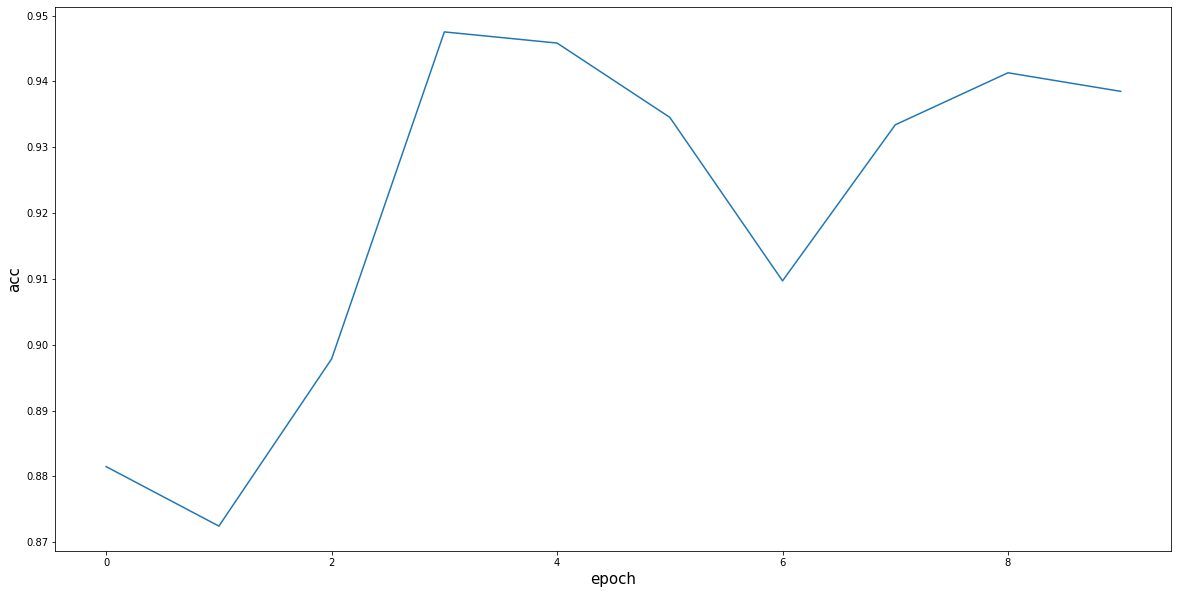

In [55]:
import matplotlib.pyplot as plt

History = model.fit(X_train,y_train, epochs=10, validation_data=(X_test,y_test))
fig = plt.figure(figsize=(20,10))
plt.plot(History.history["accuracy"])
plt.xlabel('epoch', fontsize=15)
plt.ylabel('acc', fontsize=15)

fig.savefig('accuracy.pdf', bbox_inches='tight')


In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam',metrics=[keras.metrics.Precision(), keras.metrics.Recall()])